# QUANDL

In [1]:
##USE QUANDL AND PANDAS
import quandl
import pandas as pd
def getTickerData(ticker):
    ##RETURNS A DATAFRAME WITH ONLY THE COLUMNS WE CARE ABOUT
    limitedDf = quandl.get(["EOD/" + ticker +".11"], authtoken="G3AvFe4ZUZoBEthhjmEY")
    limitedDf.columns = ["Adj_Close_" + ticker]
    return limitedDf

In [2]:
import time
import multiprocessing as mp
import sys
def cycleP(runningProcesses):
    newP = []
    for p in runningProcesses:
        if p.is_alive() == True:
            newP.append(p)
        else:
            p.join()
    return newP

def downloadTickerData(storedTickers):
    mpEngine = mp.get_context('fork')
    with mpEngine.Manager() as manager:
        returnDict = manager.dict()
        ##CHILDREN TO SPAWN
        def plainSources(tick, sharedDict):
            try:
                thisData = getTickerData(tick)

                sharedDict[tick] = thisData
                print(tick)
            except:
                sharedDict[tick] = None
                print("FAILED:", tick)
                print("APPLICABLE ETF ERROR:", str(sys.exc_info()))
        
        runningP = []
        for ticker in storedTickers:
            
            while len(runningP) > 8:
                runningP = cycleP(runningP)
            
            p = mpEngine.Process(target=plainSources, args=(ticker, returnDict, ))
            p.start()
            runningP.append(p)


        while len(runningP) > 0:
                runningP = cycleP(runningP)
        storedData = {}  
        for ticker in storedTickers:
            try:
                if returnDict[ticker] is not None:
                    storedData[ticker] = returnDict[ticker]
            except:
                continue
            
        return storedData, list(storedData.keys())

def joinDatasets(tickerDatas):
    baseTicker = tickerDatas[0]
    for ticker in tickerDatas[1:]:
        baseTicker = baseTicker.join(ticker, how='outer').dropna()
    return baseTicker

# GOOGLE CLOUD

In [3]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import numpy as np

def getAllTickersPlain():
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            query = datastore_client.query(kind=params.dataSourcesDatastoreName, projection=["ticker"], distinct_on=["ticker"])
            retrievedDatasources = list(query.fetch())
            toReturn = {}
            for source in retrievedDatasources:
                toReturn[source["ticker"]] = source["ticker"]

            return [item for item in toReturn]
        except:
            time.sleep(10)
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))

def getDataSourcesForTicker(ticker):
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            query = datastore_client.query(kind=params.dataSourcesDatastoreName)
            query.add_filter('ticker', '=', ticker)
            retrievedDatasources = list(query.fetch())
            toReturn = []
            for source in retrievedDatasources:
                toReturn.append(source["applicable_ticker"])

            return toReturn + [ticker]
        except:
            time.sleep(10)
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))

In [4]:
allTickers = getAllTickersPlain()
import random
tickerToTrade = "IWN"#allTickers[random.randint(0, len(allTickers)) - 1]
print(tickerToTrade)

IWN


In [5]:
tickersToPull = getDataSourcesForTicker(tickerToTrade)

In [6]:
pulledData, validTickers = downloadTickerData(tickersToPull)

DXJ
DVY
AGG
DIA
EFA
EWC
EWG
EWH
EWJ
EWT
GDX
IAU
GLD
FXE
EWU
IEF
EWW
IBB
IJH
IVE
IVW
IVV
IWB
IWF
IYT
IWR
IWD
LQD
SH
SDY
SLV
QQQ
OEF
RSP
SHY
SPY
USO
TIP
VGT
VIG
VO
TLT
VGK
VTI
XBI
VUG
VTV
XLB
XLK
XLI
XLE
XLP
XLU
XRT
XLV
XLY
IWN


In [7]:
joinedData = joinDatasets([pulledData[ticker] for ticker in pulledData])

In [8]:
joinedData

,Adj_Close_AGG,Adj_Close_DIA,Adj_Close_DVY,Adj_Close_DXJ,Adj_Close_EFA,Adj_Close_EWC,Adj_Close_EWG,Adj_Close_EWH,Adj_Close_EWJ,Adj_Close_EWT,...,Adj_Close_XLB,Adj_Close_XLE,Adj_Close_XLI,Adj_Close_XLK,Adj_Close_XLP,Adj_Close_XLU,Adj_Close_XLV,Adj_Close_XLY,Adj_Close_XRT,Adj_Close_IWN
Date,,,,,,,,,,,,,,,,,,,,,
2006-06-22,65.902961,82.285011,40.878626,35.467622,44.722616,17.923033,15.631528,8.913176,44.224371,17.483271,...,23.395765,41.589551,25.859019,16.660274,17.628237,20.583679,24.218334,27.471439,16.077027,54.266866
2006-06-23,65.939625,82.110542,40.707887,35.338355,44.593671,18.015515,15.596362,8.974828,44.020259,17.392117,...,23.591117,42.510521,25.924061,16.613423,17.564068,20.610365,24.237151,27.443147,16.148269,54.452870
2006-06-26,65.747141,82.431932,41.067338,35.306039,44.944689,18.255968,15.622737,8.974828,44.394465,17.483271,...,23.665537,42.975566,25.998396,16.641534,17.664906,20.699318,24.152472,27.584606,16.148269,55.168988
2006-06-27,65.930459,81.577953,40.797750,35.306039,44.113707,18.144990,15.385363,8.807486,43.612034,17.282733,...,23.367858,43.057632,25.756809,16.416648,17.582402,20.619261,23.898433,27.235673,15.844302,54.257566
2006-06-28,65.866297,82.000352,40.995448,35.306039,44.615162,18.135742,15.402946,8.895561,44.156334,17.574424,...,23.423673,43.796232,25.831144,16.529091,17.664906,20.681528,23.898433,27.263965,15.839552,54.536573
2006-06-29,66.095445,83.478745,41.687392,35.306039,46.262799,18.690634,16.062319,9.203823,46.027365,18.285423,...,24.363224,45.045469,26.379358,16.950752,17.939917,20.948386,24.312422,27.858095,16.243259,56.545423
2006-06-30,66.086280,83.469563,41.633474,37.220805,46.843054,18.847854,16.299693,9.256668,46.401571,18.303654,...,24.474854,45.191365,26.370067,16.857049,17.857414,21.019548,24.444146,27.867525,16.290754,56.991834
2006-07-03,66.187105,83.772588,41.822186,37.196568,47.086618,19.042066,16.545859,9.318320,47.218021,18.449499,...,24.772534,45.674646,26.462984,16.978862,17.958251,21.259721,24.500599,27.914678,16.290754,57.494047
2006-07-05,65.994620,83.230816,41.633474,36.461362,46.191163,18.894095,16.141443,9.203823,45.653159,17.884347,...,24.474854,45.884372,26.267857,16.716496,17.811578,21.117396,24.472372,27.650621,16.081776,56.768629


# REAL SERIES

In [9]:
def createPriceSeries(joinedData, ticker):
    return joinedData["Adj_Close_" + ticker]

# PRICE DATA MANIPULATION

In [10]:
##SERIES DATA
import pandas as pd

def diffSeries(priceVector, diffAmount):
    return (priceVector.diff(diffAmount)/priceVector).dropna()

def volSeries(priceVector, lookback):
    return (priceVector.rolling(window=lookback, center=False).std()).dropna()


In [11]:
import random
class dataSeries:
    def __init__(self, ticker):
        self.ticker = ticker
        
        self.diffDays = None
        self.secondDiffDays = None
        self.volDays = None

        ##USE DIFF
        self.diffDays = random.randint(1, 44)

        if random.uniform(0,1) < 0.5:
            self.secondDiffDays = random.randint(1, 22)
            

        if random.uniform(0,1) < 0.3:
            self.volDays = random.randint(5, 22)
        
        
    def transformJoinedData(self, joinedData):
        underlyingSeries = createPriceSeries(joinedData, self.ticker)

        if self.diffDays is not None:
            underlyingSeries = diffSeries(underlyingSeries, self.diffDays)

        if self.secondDiffDays is not None:
            underlyingSeries = diffSeries(underlyingSeries, self.secondDiffDays)

        if self.volDays is not None:
            underlyingSeries = volSeries(underlyingSeries, self.volDays)
 

        return underlyingSeries.dropna()

    def checkValidity(self, dseries):
        if pd.DataFrame(dseries).max()[0] == float("inf") or pd.DataFrame(dseries).min()[0] == float("-inf"):
            return False
        else:
            return True
            
    
    def describe(self):
        return (self.ticker, self.diffDays, self.secondDiffDays, self.volDays)

class seriesManager:
    def __init__(self, tickers):
        self.tickers = tickers
    
    def createSeries(self): ##Purpose is either GSEQ or CATALYST
        tickerToUse = self.tickers[random.randint(0, len(self.tickers)) - 1]
        return dataSeries(tickerToUse)
    
    def describe(self):
        return self.tickers

In [12]:
sManager = seriesManager(validTickers)
sManager.describe()

['AGG',
 'DIA',
 'DVY',
 'DXJ',
 'EFA',
 'EWC',
 'EWG',
 'EWH',
 'EWJ',
 'EWT',
 'EWU',
 'EWW',
 'FXE',
 'GDX',
 'GLD',
 'IAU',
 'IBB',
 'IEF',
 'IJH',
 'IVE',
 'IVV',
 'IVW',
 'IWB',
 'IWD',
 'IWF',
 'IWR',
 'IYT',
 'LQD',
 'OEF',
 'QQQ',
 'RSP',
 'SDY',
 'SH',
 'SHY',
 'SLV',
 'SPY',
 'TIP',
 'TLT',
 'USO',
 'VGK',
 'VGT',
 'VIG',
 'VO',
 'VTI',
 'VTV',
 'VUG',
 'XBI',
 'XLB',
 'XLE',
 'XLI',
 'XLK',
 'XLP',
 'XLU',
 'XLV',
 'XLY',
 'XRT',
 'IWN']

In [13]:
import numpy as np
class walkforwardInputSeries:
    def __init__(self, series, windowSize, predictionLength, targetTicker):
        self.windowSize = windowSize
        self.series = series
        self.predictionPeriod = predictionLength
        self.targetTicker = targetTicker
        print(self.describe())
    
    def generateWindows(self, dataOfInterest):
        transformedData = self.series.transformJoinedData(dataOfInterest)
        xVals = []
        yVals = []
        yIndex = []
        for i in range(len(transformedData) - self.windowSize - self.predictionPeriod):
            inputSeries = transformedData[i:i+self.windowSize]
            targetDays = transformedData[i+self.windowSize:i+self.windowSize+self.predictionPeriod]
            targetSeries = dataOfInterest["Adj_Close_" + self.targetTicker][targetDays.index]
            transformedTarget = targetSeries.apply(lambda x:(x - targetSeries[0])/targetSeries[0])
            xVals.append(np.array(inputSeries))
            yVals.append(transformedTarget[-1])
            yIndex.append(targetDays.index[0])
        return xVals, yVals, yIndex, transformedData[-self.windowSize:]
    
    def describe(self):
        return (self.windowSize, self.series.describe(), self.predictionPeriod, self.targetTicker)


In [14]:
defaultWindowSize = 20
wForward = walkforwardInputSeries(sManager.createSeries(), defaultWindowSize, 10, "AGG")
xVals, yVals, yDF, xToday = wForward.generateWindows(joinedData[:"2014-01-01"])

(20, ('SH', 17, None, None), 10, 'AGG')


In [15]:
xToday

Date
2013-12-03   -0.028758
2013-12-04   -0.014948
2013-12-05   -0.010687
2013-12-06   -0.023552
2013-12-09   -0.018196
2013-12-10   -0.009645
2013-12-11    0.006865
2013-12-12    0.006842
2013-12-13    0.004181
2013-12-16   -0.004975
2013-12-17    0.006479
2013-12-18   -0.006594
2013-12-19   -0.005814
2013-12-20   -0.012086
2013-12-23   -0.014890
2013-12-24   -0.017675
2013-12-26   -0.025257
2013-12-27   -0.029609
2013-12-30   -0.030004
2013-12-31   -0.038446
Name: Adj_Close_SH, dtype: float64

In [16]:
#Step 2 Build Model
import time
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import multiprocessing as mp
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")


# END TO END PREDICTOR

In [17]:
def computePosition(predictionsArr):
    netPos = 0.0
    for item in predictionsArr:
        if item > 0.51:
            netPos += 1.0
        elif item < 0.49:
            netPos -= 1.0
    return netPos/len(predictionsArr)

def applyBinary(predictionsArr):
    return [1.0 if item > 0.0 else -1.0 for item in predictionsArr]

In [18]:
def getDailyFactorReturn(ticker, joinedData):
    dailyFactorReturn = joinedData[["Adj_Close_" + ticker]].pct_change(1).shift(-1).dropna()
    dailyFactorReturn.columns = ["Factor Return"]
    return dailyFactorReturn


In [19]:
getDailyFactorReturn("IWN", joinedData)

,Factor Return
Date,
2006-06-22,0.003428
2006-06-23,0.013151
2006-06-26,-0.016521
2006-06-27,0.005142
2006-06-28,0.036835
2006-06-29,0.007895
2006-06-30,0.008812
2006-07-03,-0.012617
2006-07-05,0.003440


In [20]:
from sklearn.preprocessing import StandardScaler
import empyrical

class endToEnd:
    def __init__(self, walkForward, trees):
        self.walkForward = walkForward
        self.parallelism = 60
        self.treeSize = trees
        self.threshold = None
        
    @staticmethod
    def transformTargetArr(targetArr, threshold= None):
        ##IF THRESHOLD IS NONE THEN JUST BINARY
        k = 0
        joinArr = []
        while k < len(targetArr):
            if threshold is None:
                joinArr.append([1.0 if targetArr[k] > 0.0 else 0.0])
            else:
                if targetArr[k] > threshold:
                    joinArr.append(np.array([0, 0, 1]))
                elif targetArr[k] < -threshold:
                    joinArr.append(np.array([1, 0, 0]))
                else:
                    joinArr.append(np.array([0, 1, 0]))
            
            k += 1
                
        
        return joinArr
            
        
        
    def runDay(self, xVals, yVals, xTarget, identifier=None, sharedDict=None):
        scaler = StandardScaler()
        realArr = []
        for item in xVals:
            realArr.append(item[-1])
        scaler.fit(realArr)

        xSlice = [scaler.transform(item) for item in xVals]

        xTarget = scaler.transform(xTarget)

        totalModel = ExtraTreesClassifier(self.treeSize, n_jobs=1, 
                                          class_weight="balanced_subsample", 
                                          bootstrap=True) #RandomForestClassifier

        targetY = endToEnd.transformTargetArr(yVals, self.threshold)

        totalModel.fit(
            np.array(xSlice),
            np.array(targetY),
        )
        pred = None
        if self.threshold is None:
            pred = totalModel.predict_proba(np.array([xTarget]))[0][1]
        else:
            pred = np.argmax([item[0][1] for item in totalModel.predict_proba(np.array([xTarget]))]) - 1
            
        
        
        if identifier is not None:
            sharedDict[identifier] = pred
        else:
            return pred
    
    def runDayChunking(self, xVals, yVals, identifiers, sharedDict, k):
        j= 0
        for i in identifiers:
            pred = self.runDay(xVals[:int(i)], yVals[:int(i)], xVals[int(i)+44])
            sharedDict[str(i)] = pred
            j += 1
            if j % 30 == 0:
                print("THREAD ", k, "PROGRESS:", j/len(identifiers))
       
    
    
    def runModelsCHUNKINGMP(self, dataOfInterest, daysToCheck = None):
        xVals, yVals, yIndex, xToday = self.walkForward.generateWindows(dataOfInterest)
        mpEngine = mp.get_context('fork')
        with mpEngine.Manager() as manager:
            returnDict = manager.dict()
            
            identifiersToCheck = []
            
            for i in range(len(xVals) - 44): ##44 is lag 
                if i < 600:
                    ##MIN TRAINING
                    continue
                identifiersToCheck.append(str(i))
                
            if daysToCheck is not None:
                identifiersToCheck = identifiersToCheck[-daysToCheck:]
                
            splitIdentifiers = np.array_split(np.array(identifiersToCheck), self.parallelism)
            
            
            runningP = []
            k = 0
            for identifiers in splitIdentifiers:
                p = mpEngine.Process(target=endToEnd.runDayChunking, args=(self, xVals, yVals, identifiers, returnDict,k))
                p.start()
                runningP.append(p)
                
                k += 1
                

            while len(runningP) > 0:
                newP = []
                for p in runningP:
                    if p.is_alive() == True:
                        newP.append(p)
                    else:
                        p.join()
                runningP = newP
                
            
            preds = []
            actuals = []
            factorReturn = []
            returnStream = []
            days = []
            for i in identifiersToCheck:
                preds.append(returnDict[i])
                actuals.append(yVals[int(i) + 44])
                days.append(yIndex[int(i) + 44])
                
            ##CREATE ACCURATE BLENDING ACROSS DAYS
            predsTable = pd.DataFrame(preds, index=days, columns=["Predictions"])
            i = 1
            while i < self.walkForward.predictionPeriod:
                predsTable = predsTable.join(predsTable.shift(i), rsuffix="_" + str(i))
                i += 1
            
            transformedPreds = pd.DataFrame(predsTable.apply(lambda x:computePosition(x), axis=1), columns=["Predictions"]).dropna()
            dailyFactorReturn = getDailyFactorReturn(self.walkForward.targetTicker, dataOfInterest)
            transformedPreds = transformedPreds.join(dailyFactorReturn).dropna()
            returnStream = pd.DataFrame(transformedPreds.apply(lambda x:x[0] * x[1], axis=1), columns=["Algo Return"])
            factorReturn = pd.DataFrame(transformedPreds[["Factor Return"]])
            predictions = pd.DataFrame(transformedPreds[["Predictions"]])
            
            return returnStream, factorReturn, predictions
    

    def runModelToday(self, dataOfInterest):
        xVals, yVals, yIndex, xToday = self.walkForward.generateWindows(dataOfInterest)
        return self.runDay(xVals, yVals, xToday, identifier=None, sharedDict=None)
        

In [21]:
from scipy import stats

def vizResults(returnStream, factorReturn, plotting = False):
    alpha, beta = empyrical.alpha_beta(returnStream, factorReturn)
    metrics = {"SHARPE": empyrical.sharpe_ratio(returnStream),
               "STABILITY": empyrical.stability_of_timeseries(returnStream),
               "ALPHA":alpha,
               "BETA":beta,
               "ANNUALIZED RETURN": empyrical.annual_return(returnStream)[0],
               "ACTIVITY": np.count_nonzero(returnStream)/float(len(returnStream)),
               "TREYNOR": ((empyrical.annual_return(returnStream.values)[0] - empyrical.annual_return(factorReturn.values)[0]) \
                           / abs(empyrical.beta(returnStream, factorReturn))),
               "RAW BETA":empyrical.alpha_beta(returnStream.apply(lambda x:applyBinary(x), axis=0), factorReturn.apply(lambda x:applyBinary(x), axis=0))[1]
                  
              }
    rollingPeriod = 252
    
    rollingSharpe = returnStream.rolling(rollingPeriod, min_periods=rollingPeriod).apply(lambda x:empyrical.sharpe_ratio(x)).dropna()
    rollingSharpe.columns = ["252 Day Rolling Sharpe"]
    rollingSharpeFactor = factorReturn.rolling(rollingPeriod, min_periods=rollingPeriod).apply(lambda x:empyrical.sharpe_ratio(x)).dropna()
    rollingSharpe = rollingSharpe.join(rollingSharpeFactor)
    rollingSharpe.columns = ["252 Day Rolling Sharpe Algo", "252 Day Rolling Sharpe Factor"]
    
    if len(rollingSharpe["252 Day Rolling Sharpe Algo"].values) > 50:
    
        metrics["ROLLING SHARPE BETA"] = empyrical.beta(rollingSharpe["252 Day Rolling Sharpe Algo"], rollingSharpe["252 Day Rolling Sharpe Factor"])
        metrics["25TH PERCENTILE SHARPE"] = np.percentile(rollingSharpe["252 Day Rolling Sharpe Algo"].values, 25)

        rollingDownside = returnStream.rolling(rollingPeriod, min_periods=rollingPeriod).apply(lambda x:empyrical.max_drawdown(x)).dropna()
        rollingDownside.columns = ["252 Day Rolling Downside"]
        rollingDownsideFactor = factorReturn.rolling(rollingPeriod, min_periods=rollingPeriod).apply(lambda x:empyrical.max_drawdown(x)).dropna()
        rollingDownside = rollingDownside.join(rollingDownsideFactor)
        rollingDownside.columns = ["252 Day Rolling Downside Algo", "252 Day Rolling Downside Factor"]

        metrics["ROLLING SHARPE STABILITY"] = stats.linregress(np.arange(len(rollingSharpe["252 Day Rolling Sharpe Algo"].values)),
                                rollingSharpe["252 Day Rolling Sharpe Algo"].values).rvalue
    
        metrics["TREYNOR+"] = ((empyrical.annual_return(returnStream.values)[0] - empyrical.annual_return(factorReturn.values)[0]) \
                               / (abs(empyrical.beta(returnStream, factorReturn)))) * abs(metrics["ROLLING SHARPE STABILITY"])


        rollingReturn = returnStream.rolling(rollingPeriod, min_periods=rollingPeriod).apply(lambda x:empyrical.cum_returns(x)[-1]).dropna()
        rollingReturn.columns = ["ROLLING RETURN"]
        metrics["SMART INFORMATION RATIO"] = (np.percentile(rollingReturn["ROLLING RETURN"].values, 25) - empyrical.annual_return(factorReturn.values[0]))\
                        / returnStream.values.std()

        metrics["ROLLING SHARPE ERROR"] = rollingSharpe["252 Day Rolling Sharpe Algo"].std()
        if plotting == True:
            %matplotlib inline
            import matplotlib.pyplot as plt 
            rollingSharpe.plot()
            rollingDownside.plot()

    
    returns = returnStream.apply(lambda x:empyrical.cum_returns(x))
    returns.columns = ["algo"]
    factorReturn = factorReturn.apply(lambda x:empyrical.cum_returns(x))
    returns = returns.join(factorReturn)
    returns.columns = ["Algo Return", "Factor Return"]


        ##FORCE SHOW
    if plotting == True:
        %matplotlib inline
        import matplotlib.pyplot as plt 
        returns.plot()
        plt.show()
    return metrics

# STANDALONE MODULE

In [22]:
class algoBlob:
    def __init__(self, inputSeries, windowSize, trees, predictionLength, targetTicker):
        self.inputSeries = walkforwardInputSeries(inputSeries, windowSize, predictionLength, targetTicker)
        self.windowSize = windowSize
        self.trees = trees
        self.e2e = endToEnd(self.inputSeries, trees)
        print("SERIES", self.inputSeries.describe(), "WINDOW", defaultWindowSize, "TREES", trees)
    
    def makePredictions(self, dataOfInterest, daysToCheck = None):
        #algoReturn, factorReturn, predictions 
        return self.e2e.runModelsCHUNKINGMP(dataOfInterest, daysToCheck)
    
    def makeTodayPrediction(self, dataOfInterest):
        return self.e2e.runModelToday(dataOfInterest)
    
    def describe(self):
        return (self.inputSeries.describe(), self.windowSize, self.trees)

In [23]:
def logModel(topic, message):
    while True:
        try:
            loggingClient = logging.Client('money-maker-1236')
            logger = loggingClient.logger(topic.replace(" ", ""))
            logger.log_struct(message)
            break
        except:
            time.sleep(10)
            print("LOGGING ERROR:", str(sys.exc_info()))

def storeModel(model, trainingMetrics, oosMetrics):
    toUpload = trainingMetrics
    for k in oosMetrics:
        toUpload["OOS_" + k] = oosMetrics[k]
    toUpload["ticker"] = model.inputSeries.targetTicker
    toUpload["predictionLength"] = model.inputSeries.predictionPeriod
    toUpload["model"] = pickle.dumps(model)
    organismHash = hashlib.sha224(str(model.describe()).encode('utf-8')).hexdigest()
    ##UPLOAD ORGANISM OBJECT
    while True:
        try:
            datastoreClient = datastore.Client('money-maker-1236')
            #HASH DIGEST
            key = datastoreClient.key(params.datastoreName,  organismHash) #NEED TO HASH TO ENSURE UNDER COUNT
            organismToStore = datastore.Entity(key=key, exclude_from_indexes=["model"])
            organismToStore.update(toUpload)
            datastoreClient.put(organismToStore)
            break
        except:
            print("UPLOAD ERROR:", str(sys.exc_info()))
            time.sleep(10)
    
    ##LOG SUCCESSFUL STORE
    toLog = {}
    for item in toUpload:
        if item != "model":
            toLog[item] = toUpload[item]
        else:
            toLog[item] = str(model.describe())
    logModel("StoredModel", toLog)
    

(10, ('XLU', 42, None, None), 2, 'IWN')
SERIES (10, ('XLU', 42, None, None), 2, 'IWN') WINDOW 10 TREES 25
THREAD  2 PROGRESS: 0.8333333333333334
THREAD  0 PROGRESS: 0.8333333333333334
THREAD  4 PROGRESS: 0.8333333333333334
THREAD  1 PROGRESS: 0.8333333333333334
THREAD  12 PROGRESS: 0.8571428571428571
THREAD  3 PROGRESS: 0.8333333333333334
THREAD  6 PROGRESS: 0.8571428571428571
THREAD  5 PROGRESS: 0.8333333333333334
THREAD  7 PROGRESS: 0.8571428571428571
THREAD  8 PROGRESS: 0.8571428571428571
THREAD  9 PROGRESS: 0.8571428571428571
THREAD  10 PROGRESS: 0.8571428571428571
THREAD  18 PROGRESS: 0.8571428571428571
THREAD  11 PROGRESS: 0.8571428571428571
THREAD  13 PROGRESS: 0.8571428571428571
THREAD  21 PROGRESS: 0.8571428571428571
THREAD  15 PROGRESS: 0.8571428571428571
THREAD  19 PROGRESS: 0.8571428571428571
THREAD  14 PROGRESS: 0.8571428571428571
THREAD  17 PROGRESS: 0.8571428571428571
THREAD  16 PROGRESS: 0.8571428571428571
THREAD  20 PROGRESS: 0.8571428571428571
THREAD  22 PROGRESS: 0.8

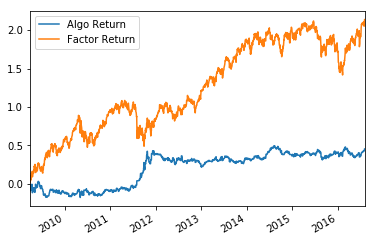

TRAIN: {'SHARPE': 0.39348279031205446, 'STABILITY': 0.74676271474207767, 'ALPHA': 0.044493360010321815, 'BETA': 0.10955210309714143, 'ANNUALIZED RETURN': 0.052152940044477569, 'ACTIVITY': 0.5577130528586839, 'TREYNOR': -1.0593944028042686, 'RAW BETA': 0.13379695484958645, 'ROLLING SHARPE BETA': -0.2665330981566898, '25TH PERCENTILE SHARPE': -0.034151617613852527, 'ROLLING SHARPE STABILITY': -0.22229748077762743, 'TREYNOR+': -0.23550070689330799, 'SMART INFORMATION RATIO': -8366.7307011042576, 'ROLLING SHARPE ERROR': 0.7209782499527411}


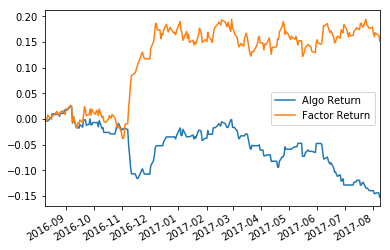

TEST: {'SHARPE': -1.3096882216131933, 'STABILITY': 0.53838217302582314, 'ALPHA': -0.19650797876303683, 'BETA': 0.25435780692417198, 'ANNUALIZED RETURN': -0.15246055481126608, 'ACTIVITY': 0.5753968253968254, 'TREYNOR': -1.1943147935960789, 'RAW BETA': 0.23190416141235978}
TODAY: 0.44
(10, ('XLU', 42, None, None), 3, 'IWN')
SERIES (10, ('XLU', 42, None, None), 3, 'IWN') WINDOW 10 TREES 25
THREAD  0 PROGRESS: 0.8333333333333334
THREAD  1 PROGRESS: 0.8333333333333334
THREAD  2 PROGRESS: 0.8333333333333334
THREAD  5 PROGRESS: 0.8571428571428571
THREAD  8 PROGRESS: 0.8571428571428571
THREAD  3 PROGRESS: 0.8333333333333334
THREAD  4 PROGRESS: 0.8333333333333334
THREAD  6 PROGRESS: 0.8571428571428571
THREAD  9 PROGRESS: 0.8571428571428571
THREAD  7 PROGRESS: 0.8571428571428571
THREAD  11 PROGRESS: 0.8571428571428571
THREAD  10 PROGRESS: 0.8571428571428571
THREAD  15 PROGRESS: 0.8571428571428571
THREAD  14 PROGRESS: 0.8571428571428571
THREAD  16 PROGRESS: 0.8571428571428571
THREAD  12 PROGRESS:

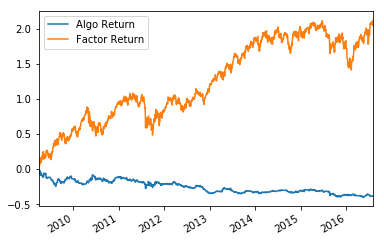

TRAIN: {'SHARPE': -0.40363122245534322, 'STABILITY': 0.85064263040490518, 'ALPHA': -0.08585527286062988, 'BETA': 0.17437953517119828, 'ANNUALIZED RETURN': -0.061770725884053634, 'ACTIVITY': 0.7388019427954668, 'TREYNOR': -1.3189824978277731, 'RAW BETA': 0.23652099520678882, 'ROLLING SHARPE BETA': -0.0091622669201238283, '25TH PERCENTILE SHARPE': -0.71711630146040028, 'ROLLING SHARPE STABILITY': -0.16576635710946633, 'TREYNOR+': -0.21864292375605454, 'SMART INFORMATION RATIO': -10084.712161336916, 'ROLLING SHARPE ERROR': 0.5944487143411898}


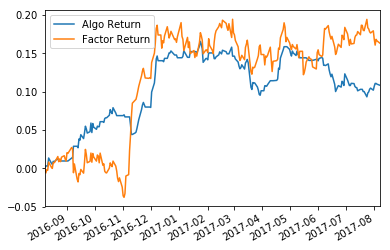

TEST: {'SHARPE': 1.319622869072905, 'STABILITY': 0.43860111598766888, 'ALPHA': 0.07707461254767331, 'BETA': 0.18043878961055154, 'ANNUALIZED RETURN': 0.10847641327406565, 'ACTIVITY': 0.6984126984126984, 'TREYNOR': -0.30515989526465015, 'RAW BETA': 0.32614861032331355}
TODAY: 0.32
(10, ('XLU', 42, None, None), 5, 'IWN')
SERIES (10, ('XLU', 42, None, None), 5, 'IWN') WINDOW 10 TREES 25
THREAD  7 PROGRESS: 0.8571428571428571
THREAD  0 PROGRESS: 0.8333333333333334
THREAD  4 PROGRESS: 0.8571428571428571
THREAD  1 PROGRESS: 0.8333333333333334
THREAD  3 PROGRESS: 0.8571428571428571
THREAD  2 PROGRESS: 0.8333333333333334
THREAD  10 PROGRESS: 0.8571428571428571
THREAD  5 PROGRESS: 0.8571428571428571
THREAD  6 PROGRESS: 0.8571428571428571
THREAD  8 PROGRESS: 0.8571428571428571
THREAD  15 PROGRESS: 0.8571428571428571
THREAD  11 PROGRESS: 0.8571428571428571
THREAD  9 PROGRESS: 0.8571428571428571
THREAD  13 PROGRESS: 0.8571428571428571
THREAD  12 PROGRESS: 0.8571428571428571
THREAD  16 PROGRESS: 0.

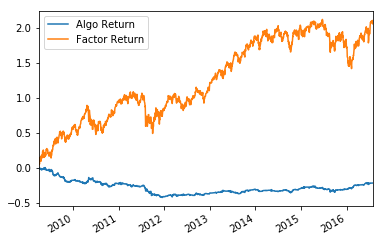

TRAIN: {'SHARPE': -0.28671756815618293, 'STABILITY': 0.20832283247334873, 'ALPHA': -0.05048042878044003, 'BETA': 0.12335537112271995, 'ANNUALIZED RETURN': -0.033106146739170339, 'ACTIVITY': 0.915180983252296, 'TREYNOR': -1.6108426405752405, 'RAW BETA': 0.28544000563658262, 'ROLLING SHARPE BETA': 0.32806272884937265, '25TH PERCENTILE SHARPE': -1.0295240683457223, 'ROLLING SHARPE STABILITY': 0.69588013566333784, 'TREYNOR+': -1.1209533952557877, 'SMART INFORMATION RATIO': -13655.280803438558, 'ROLLING SHARPE ERROR': 0.9753538058243758}


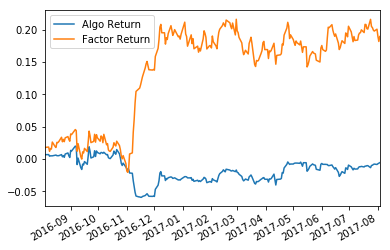

TEST: {'SHARPE': -0.041238385013794378, 'STABILITY': 0.037362144810233568, 'ALPHA': -0.0646057402965423, 'BETA': 0.33511542644097042, 'ANNUALIZED RETURN': -0.0057315121828793725, 'ACTIVITY': 0.9246031746031746, 'TREYNOR': -0.58219736144026746, 'RAW BETA': 0.73751181102362706}
TODAY: 0.52
(10, ('XLU', 42, None, None), 2, 'IWN')
SERIES (10, ('XLU', 42, None, None), 2, 'IWN') WINDOW 10 TREES 50
THREAD  0 PROGRESS: 0.8333333333333334
THREAD  3 PROGRESS: 0.8333333333333334
THREAD  2 PROGRESS: 0.8333333333333334
THREAD  1 PROGRESS: 0.8333333333333334
THREAD  4 PROGRESS: 0.8333333333333334
THREAD  6 PROGRESS: 0.8571428571428571
THREAD  8 PROGRESS: 0.8571428571428571
THREAD  5 PROGRESS: 0.8333333333333334
THREAD  7 PROGRESS: 0.8571428571428571
THREAD  10 PROGRESS: 0.8571428571428571
THREAD  12 PROGRESS: 0.8571428571428571
THREAD  14 PROGRESS: 0.8571428571428571
THREAD  9 PROGRESS: 0.8571428571428571
THREAD  13 PROGRESS: 0.8571428571428571
THREAD  11 PROGRESS: 0.8571428571428571
THREAD  19 PROG

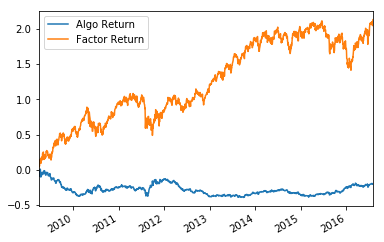

TRAIN: {'SHARPE': -0.10835104931868415, 'STABILITY': 0.14074618796450922, 'ALPHA': -0.05432673016920316, 'BETA': 0.20611149122131076, 'ANNUALIZED RETURN': -0.029867465050420816, 'ACTIVITY': 0.6510248112189859, 'TREYNOR': -0.96102982302311302, 'RAW BETA': 0.21590011063695203, 'ROLLING SHARPE BETA': -0.65507807971888354, '25TH PERCENTILE SHARPE': -0.73238458944704754, 'ROLLING SHARPE STABILITY': 0.3065972138964651, 'TREYNOR+': -0.2946490662102994, 'SMART INFORMATION RATIO': -8492.9899682372052, 'ROLLING SHARPE ERROR': 1.0929768341031219}


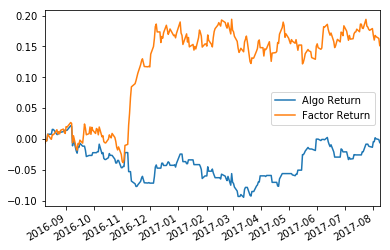

TEST: {'SHARPE': -0.0025127212202086411, 'STABILITY': 0.017120097304077923, 'ALPHA': -0.04813641500945972, 'BETA': 0.3167537525300006, 'ANNUALIZED RETURN': -0.0060729088208165694, 'ACTIVITY': 0.6111111111111112, 'TREYNOR': -0.49690222902990516, 'RAW BETA': 0.36721311475409796}
TODAY: 0.44
(10, ('XLU', 42, None, None), 3, 'IWN')
SERIES (10, ('XLU', 42, None, None), 3, 'IWN') WINDOW 10 TREES 50


Process ForkProcess-1986:
Process ForkProcess-1980:
Process ForkProcess-1971:
Process ForkProcess-1983:
Process ForkProcess-1966:
Process ForkProcess-1989:
Process ForkProcess-1988:
Process ForkProcess-1998:
Process ForkProcess-1991:
Process ForkProcess-1977:
Process ForkProcess-1963:
Process ForkProcess-2011:
Process ForkProcess-1974:
Process ForkProcess-2013:
Process ForkProcess-1999:
Process ForkProcess-1956:
Process ForkProcess-2004:
Process ForkProcess-1982:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkProcess-2003:
Process ForkProcess-1973:
Traceback (most recent call last):
Process ForkProcess-1979:
Process ForkProcess-2014:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/prohb125/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/prohb125/anaconda3/

FAILED ('XLU', 42, None, None)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "<ipython-input-76-82f65439f61a>", line 12, in <module>
    algoReturn, factorReturn, predictions =  b.makePredictions(joinedData)
  File "<ipython-input-74-1b42ef99f882>", line 11, in makePredictions
    return self.e2e.runModelsCHUNKINGMP(dataOfInterest, daysToCheck)
  File "<ipython-input-72-ad0bfb4b0cbb>", line 112, in runModelsCHUNKINGMP
    if p.is_alive() == True:
  File "/home/prohb125/anaconda3/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    self._popen.poll()
  File "/home/prohb125/anaconda3/lib/python3.6/multiprocessing/popen_fork.py", line 29, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/prohb125/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-76-82f

TypeError: must be str, not list

In [76]:
##GET ALGOS INITIALLY GOOD
for i in range(5):
    s = sManager.createSeries()
    while s.checkValidity(s.transformJoinedData(joinedData[:"2015-01-01"])) == False:
        s = sManager.createSeries()

    try:
        for defaultWindowSize in [10, 22]:
            for trees in [25, 50, 100]:
                for predictionLength in [2, 3, 5]:
                    b = algoBlob(s, defaultWindowSize, trees, predictionLength, tickerToTrade)
                    algoReturn, factorReturn, predictions =  b.makePredictions(joinedData)
                    metrics = vizResults(algoReturn[:-252], factorReturn[:-252], True)
                    print("TRAIN:", metrics)
                    if metrics["SHARPE"] > -10.0:
                        ##STORE
                        testMetrics = vizResults(algoReturn[-252:], factorReturn[-252:], True)
                        print("TEST:", testMetrics)
                        print("TODAY:", b.makeTodayPrediction(joinedData))

                        storeModel(b, metrics, testMetrics)
    except:
        print("FAILED", s.describe())
        time.sleep(10)
        

# PORTFOLIO

In [24]:
def getModels(ticker = None):
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            query = datastore_client.query(kind=params.datastoreName)
            if ticker is not None:
                query.add_filter('ticker', '=', ticker)
            retrievedModels = list(query.fetch())
            toReturn = []
            for source in retrievedModels:
                toReturn.append(pickle.loads(source["model"]))
            return toReturn
        except:
            time.sleep(10)
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))

In [25]:
allModels = getModels()
for mod in allModels:
    print(mod.describe())

((10, ('XLU', 42, None, None), 3, 'IWN'), 10, 25)
((10, ('XLU', 42, None, None), 5, 'IWN'), 10, 25)
((10, ('XLU', 42, None, None), 2, 'IWN'), 10, 50)
((10, ('XLU', 42, None, None), 2, 'IWN'), 10, 25)


In [26]:
def generateAggregateReturns(allModels, joinedData):
    aggregateReturns = None
    for mod in allModels:
        print(mod.describe())
        algoReturn, factorReturn, predictions =  mod.makePredictions(joinedData, 300) ##ONLY GET LAST 300 PREDICTIONS
#         print("TRAIN:", vizResults(algoReturn[:-252], factorReturn[:-252], True))
#         print("TEST:", vizResults(algoReturn[-252:], factorReturn[-252:], True))
        algoReturn.columns = [str(mod.describe())]
        if aggregateReturns is None:
            aggregateReturns = algoReturn
        else:
            aggregateReturns = aggregateReturns.join(algoReturn)
    return aggregateReturns

In [27]:
##GET ALGOS INITIALLY GOOD
aggregateReturns = generateAggregateReturns(allModels, joinedData)


((10, ('XLU', 42, None, None), 3, 'IWN'), 10, 25)
((10, ('XLU', 42, None, None), 5, 'IWN'), 10, 25)
((10, ('XLU', 42, None, None), 2, 'IWN'), 10, 50)
((10, ('XLU', 42, None, None), 2, 'IWN'), 10, 25)


In [28]:
##USE HRP
import hrpPortfolioOpt as hrp

##GENERATE EACH ALGO RETURN
def simpleTransform(inputArr):
    toReturn = []
    for item in inputArr:
        if item > 0.5:
            toReturn.append(1.0)
        elif item < 0.5:
            toReturn.append(-1.0)
        else:
            toReturn.append(0.0)
    return toReturn
def produceHRPPredictions(aggregateReturns, windowSize, maxWindowSize = False):
    hrpReturns = pd.DataFrame([])
    i = windowSize
    while i < len(aggregateReturns):
        corr = None
        cov = None
        if maxWindowSize == False:
            corr = (aggregateReturns[:i]).corr()
            cov = (aggregateReturns[:i]).cov()
        else:
            corr = (aggregateReturns[i-windowSize:i]).corr()
            cov = (aggregateReturns[i-windowSize:i]).cov()
        weights = hrp.getHRP(cov, corr)
    #     display(weights)
    #     display(aggregateReturns[i+windowSize:i+windowSize+1])
        todayReturn = aggregateReturns[i:i+1] * weights
    #     display(todayReturn)
        sumReturn = pd.DataFrame(todayReturn.apply(lambda x:sum(x), axis=1))
        hrpReturns = pd.concat([hrpReturns, sumReturn])
        i += 1
    return hrpReturns, weights


In [29]:
hrpReturns, weights = produceHRPPredictions(aggregateReturns, 22, True)

In [30]:
weights

((10, ('XLU', 42, None, None), 2, 'IWN'), 10, 25)    0.128682
((10, ('XLU', 42, None, None), 2, 'IWN'), 10, 50)    0.102786
((10, ('XLU', 42, None, None), 3, 'IWN'), 10, 25)    0.177851
((10, ('XLU', 42, None, None), 5, 'IWN'), 10, 25)    0.590680
dtype: float64

In [31]:
factorReturn = hrpReturns.join(pd.DataFrame(getDailyFactorReturn("IWN", joinedData))).dropna()[["Factor Return"]]

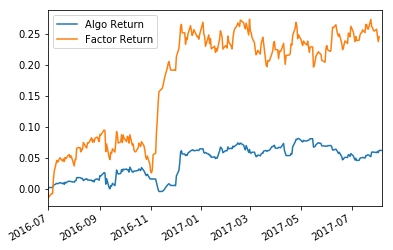

{'ACTIVITY': 0.9784172661870504,
 'ALPHA': 0.0042631771310530095,
 'ANNUALIZED RETURN': 0.05622876584879144,
 'BETA': 0.24977794877239792,
 'RAW BETA': 0.54327731092436982,
 'SHARPE': 0.93163273880814113,
 'STABILITY': 0.62611416179709511,
 'TREYNOR': -0.66518224654762326}

In [32]:
vizResults(hrpReturns, factorReturn[-len(hrpReturns):], True)

# USE WEIGHTS FOR PORTFOLIO

In [33]:
import params
def storeModelPrediction(model, pred, lastDataDayUsed):
    toUpload = {}
    toUpload["ticker"] = model.inputSeries.targetTicker
    toUpload["predictionLength"] = model.inputSeries.predictionPeriod
    toUpload["model"] = str(model.describe())
    toUpload["prediction"] = pred
    toUpload["lastDataDayUsed"] = lastDataDayUsed
    ##UPLOAD ORGANISM OBJECT
    while True:
        try:
            datastoreClient = datastore.Client('money-maker-1236')
            #HASH DIGEST
            predictionHash = hashlib.sha224((str(model.describe()) + " " + str(toUpload["lastDataDayUsed"])).encode('utf-8')).hexdigest()
            key = datastoreClient.key(params.predictionsName, predictionHash) #NEED TO HASH TO ENSURE NON-OVERLAPPING PREDICTIONS
            organismToStore = datastore.Entity(key=key)
            organismToStore.update(toUpload)
            datastoreClient.put(organismToStore)
            break
        except:
            print("UPLOAD ERROR:", str(sys.exc_info()))
            time.sleep(10)

In [37]:
##MAKE TODAY PREDICTION
for mod in allModels:
    pred = computePosition([mod.makeTodayPrediction(joinedData)])
    print(mod.describe(), pred, pred * weights[str(mod.describe())])
    storeModelPrediction(mod, pred * weights[str(mod.describe())], joinedData.index[-1])
    

((10, ('XLU', 42, None, None), 3, 'IWN'), 10, 25) -1.0 -0.177851498899
((10, ('XLU', 42, None, None), 5, 'IWN'), 10, 25) 1.0 0.590680326657
((10, ('XLU', 42, None, None), 2, 'IWN'), 10, 50) 0.0 0.0
((10, ('XLU', 42, None, None), 2, 'IWN'), 10, 25) 1.0 0.128681961001


In [40]:
def getModelPrediction(ticker = None):
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            query = datastore_client.query(kind=params.predictionsName)
            if ticker is not None:
                query.add_filter('ticker', '=', ticker)
            retrievedPredictions = list(query.fetch())
            toReturn = []
            for pred in retrievedPredictions:
                toReturn.append(pred)
            return toReturn
        except:
            time.sleep(10)
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))

def getTickersWithModel():
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            query = datastore_client.query(kind=params.datastoreName, projection=["ticker"], distinct_on=["ticker"])
            retrievedDatasources = list(query.fetch())
            toReturn = {}
            for source in retrievedDatasources:
                toReturn[source["ticker"]] = source["ticker"]

            return [item for item in toReturn]
        except:
            time.sleep(10)
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))
    

In [41]:
##TAKE WEIGHTS FROM PORTFOLIO
for ticker in getTickersWithModel():
    netPosition = 0.0
    for pred in getModelPrediction(ticker):
        ##CHECK IF PREDICTION STILL VALID
        if len(joinedData[str(pred["lastDataDayUsed"]):]) - 1 < pred["predictionLength"]:##GETS TRADING DAYS SINCE LAST DATA DAY
            ##MUST DO -1 BECAUSE INCLUDES DAY LAST USED IN LEN
#             print(pred["ticker"], pred["prediction"])
            netPosition += pred["prediction"]
    print(ticker, netPosition)

IWN 0.541510788758161
